## Facial emotion recognition
- This is an ipynb file created in Kaggle environment.
- CNN

#### Dataset
- MMA FACIAL EXPRESSION, https://www.kaggle.com/mahmoudima/mma-facial-expression

## 0. Import Packages

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras import Model, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
import os

## 1. Make dataset

In [10]:
batch_size = 128
img_height = 64
img_width = 64
preprocessed_training = []
preprocessed_validation = []

In [11]:
train_datagen = ImageDataGenerator(
        preprocessing_function = preprocess_input,  ### change
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)    
test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)

In [12]:
train_generator = train_datagen.flow_from_directory("/kaggle/input/mma-facial-expression/MMAFEDB/train",
                                                      target_size=(img_width, img_height),
                                                      batch_size=batch_size,
                                                      class_mode='categorical')
validation_generator = validation_datagen.flow_from_directory("/kaggle/input/mma-facial-expression/MMAFEDB/valid",
                                                      target_size=(img_width, img_height),
                                                      batch_size=batch_size,
                                                      class_mode='categorical')
test_generator = test_datagen.flow_from_directory("/kaggle/input/mma-facial-expression/MMAFEDB/test",
                                                      target_size=(img_width, img_height),
                                                      batch_size=batch_size,
                                                      class_mode='categorical')

Found 92968 images belonging to 7 classes.
Found 17356 images belonging to 7 classes.
Found 17356 images belonging to 7 classes.


## 2. Model (CNN)

In [13]:
# params
classes = 7
nb_epoch = 50
num_train = 92968
num_val = 17356

In [14]:
model = tf.keras.models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape = (img_width, img_height,3)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 30, 30, 256)      

In [15]:
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## 3. Training

In [16]:
hist = model.fit(
    train_generator,
    epochs = nb_epoch,
    steps_per_epoch = num_train//batch_size,
    validation_data = validation_generator,
    validation_steps = num_val//batch_size)

Epoch 1/50
726/726 [==============================] - 407s 560ms/step - loss: 4.0667 - accuracy: 0.3630 - val_loss: 3.7496 - val_accuracy: 0.2440
Epoch 2/50
726/726 [==============================] - 276s 380ms/step - loss: 3.3027 - accuracy: 0.4217 - val_loss: 3.1986 - val_accuracy: 0.3304
Epoch 3/50
726/726 [==============================] - 264s 364ms/step - loss: 2.8259 - accuracy: 0.4380 - val_loss: 2.7406 - val_accuracy: 0.3385
Epoch 4/50
726/726 [==============================] - 261s 360ms/step - loss: 2.4588 - accuracy: 0.4575 - val_loss: 2.4428 - val_accuracy: 0.3952
Epoch 5/50
726/726 [==============================] - 263s 362ms/step - loss: 2.1811 - accuracy: 0.4702 - val_loss: 2.1195 - val_accuracy: 0.4217
Epoch 6/50
726/726 [==============================] - 267s 368ms/step - loss: 1.9613 - accuracy: 0.4856 - val_loss: 2.0795 - val_accuracy: 0.3946
Epoch 7/50
726/726 [==============================] - 266s 366ms/step - loss: 1.7951 - accuracy: 0.4965 - val_loss: 1.9447 -

In [17]:
# Save model
model.save("/kaggle/working/my_model.h5")
# model.save_weigths("/kaggle/working/xception_weights.h5")

my_model_json = model.to_json()

with open("/kaggle/working/my_model.json", "w") as json_file:
    json_file.write(my_model_json)

In [18]:
model = load_model('/kaggle/working/my_model.h5')

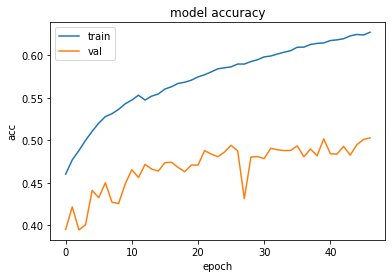

In [19]:
plt.plot(hist.history['accuracy'][3:50])
plt.plot(hist.history['val_accuracy'][3:50])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## 4. Evaluation

In [20]:
print("-- Evaluate --")
scores = model.evaluate(test_generator, steps=num_val//batch_size)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

-- Evaluate --
135/135 [==============================] - 86s 637ms/step - loss: 1.3461 - accuracy: 0.5267
accuracy: 52.67%


In [21]:
print("-- Predict --")
pred = model.predict(test_generator, steps=num_val//batch_size)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(test_generator.class_indices)
print(pred)

-- Predict --
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
[[0.048 0.026 0.036 ... 0.442 0.122 0.033]
 [0.006 0.023 0.002 ... 0.392 0.291 0.003]
 [0.021 0.051 0.016 ... 0.283 0.155 0.086]
 ...
 [0.043 0.108 0.043 ... 0.483 0.175 0.050]
 [0.081 0.175 0.081 ... 0.108 0.125 0.171]
 [0.019 0.014 0.008 ... 0.633 0.038 0.020]]


In [22]:
prediction = np.argmax(pred, axis=1)

In [23]:
test_generator.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [24]:
img, label = test_generator.next()
print(np.shape(img), np.shape(label))

(128, 64, 64, 3) (128, 7)
